In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('titanic_original.csv',header = True,inferSchema=True)
df.show(5,truncate = False)

+------+--------+-----------------------------------------------+------+------+-----+-----+------+--------+-------+--------+----+----+-------------------------------+
|pclass|survived|name                                           |sex   |age   |sibsp|parch|ticket|fare    |cabin  |embarked|boat|body|home.dest                      |
+------+--------+-----------------------------------------------+------+------+-----+-----+------+--------+-------+--------+----+----+-------------------------------+
|1     |1       |Allen, Miss. Elisabeth Walton                  |female|29.0  |0    |0    |24160 |211.3375|B5     |S       |2   |null|St Louis, MO                   |
|1     |1       |Allison, Master. Hudson Trevor                 |male  |0.9167|1    |2    |113781|151.55  |C22 C26|S       |11  |null|Montreal, PQ / Chesterville, ON|
|1     |0       |Allison, Miss. Helen Loraine                   |female|2.0   |1    |2    |113781|151.55  |C22 C26|S       |null|null|Montreal, PQ / Chesterville, ON

In [2]:
def size_shape(df):
    print('Number of Rows = %d'%df.count())
    print('Number of Columns = %d'%len(df.dtypes))
size_shape(df)

Number of Rows = 1310
Number of Columns = 14


In [3]:
#NA analysis
import pyspark.sql.functions as fn


df = df.withColumnRenamed('home.dest','home_dest')
df.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in df.columns]).show()

+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+---------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|home_dest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+---------+
|     1|       1|   1|  1|264|    1|    1|     1|   2| 1015|       3| 824|1189|      565|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+---------+



In [4]:
df.show(5)

+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|pclass|survived|                name|   sex|   age|sibsp|parch|ticket|    fare|  cabin|embarked|boat|body|           home_dest|
+------+--------+--------------------+------+------+-----+-----+------+--------+-------+--------+----+----+--------------------+
|     1|       1|Allen, Miss. Elis...|female|  29.0|    0|    0| 24160|211.3375|     B5|       S|   2|null|        St Louis, MO|
|     1|       1|Allison, Master. ...|  male|0.9167|    1|    2|113781|  151.55|C22 C26|       S|  11|null|Montreal, PQ / Ch...|
|     1|       0|Allison, Miss. He...|female|   2.0|    1|    2|113781|  151.55|C22 C26|       S|null|null|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|  30.0|    1|    2|113781|  151.55|C22 C26|       S|null| 135|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|  25.0|    1|    2|113781|  151.55|C22 C26|       S|

In [5]:
df.dtypes

[('pclass', 'int'),
 ('survived', 'int'),
 ('name', 'string'),
 ('sex', 'string'),
 ('age', 'double'),
 ('sibsp', 'int'),
 ('parch', 'int'),
 ('ticket', 'string'),
 ('fare', 'double'),
 ('cabin', 'string'),
 ('embarked', 'string'),
 ('boat', 'string'),
 ('body', 'int'),
 ('home_dest', 'string')]

In [4]:
#Removing columns Boat,cabin,body due to more number of NAs
cols = ['boat','body','cabin']
df = df.drop(*cols)
#Removing the NAs from the other columns
df = df.dropna(subset = ['name','sex','ticket','embarked','home_dest'])
#For numerical columns.. fill the na with its median
numeric_cols = ['pclass','survived','age','sibsp','parch','fare']
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=numeric_cols, 
    outputCols=[c for c in numeric_cols],
    strategy = 'median'
)
df_new = imputer.fit(df).transform(df)

In [7]:
size_shape(df_new)

Number of Rows = 744
Number of Columns = 11


In [8]:
df_new.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in df_new.columns]).show()

+------+--------+----+---+---+-----+-----+------+----+--------+---------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|embarked|home_dest|
+------+--------+----+---+---+-----+-----+------+----+--------+---------+
|     0|       0|   0|  0|  0|    0|    0|     0|   0|       0|        0|
+------+--------+----+---+---+-----+-----+------+----+--------+---------+



In [9]:
#Since I am using a small dataset, I am converting into pandas for visualisations. However it woud'nt be the case for large datasets with TBs of data.
pandas_df = df_new.toPandas()

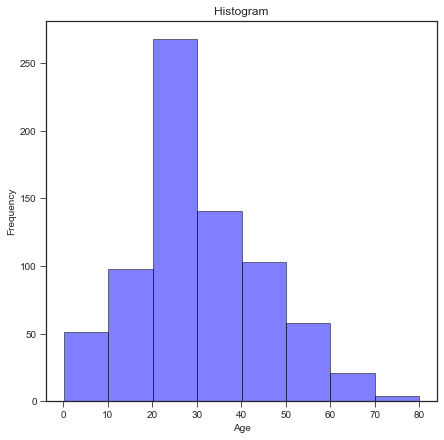

In [10]:
#Now that it is cleaned, Let us understand the dataset.#Let us understand the Age distribution

import matplotlib.pyplot as plt


plt.figure(figsize=(7,7))
#Use this line to set the graph style
plt.style.use('seaborn-ticks')
#This displays the set of available styles
# print(plt.style.available)
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title("Histogram")
#Density stands for if you want to represent the proportions as a percentage or as a frequency. 
#The Label stands for the legend
# the edge color is the border color
# The color stands for the color of the bars
# The alpha stands for how intense you want the color 'blue'
# The bins for number of bins you want to set for the data
plt.hist(pandas_df['age'], density=False, bins=8,edgecolor = 'black',color = 'blue',alpha = 0.5)




#If your graph has a legend, use this to modify the location
# plt.legend(loc="upper left")

#Using this statement will only show the graphs and not other parameters and the graph objects
plt.show()
 

In [11]:
#Let us see the Age vs Survived
# Creating a new variable - with binning the Age column
import pandas as pd
age_bins = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
pandas_df['age_group'] = pd.cut(pandas_df.age, range(0, 81, 10), right=False, labels=age_bins)
age_survived = pd.crosstab(pandas_df['age_group'],pandas_df['survived'])
age_survived.columns = ['Not_survived','Survived']

In [12]:

age_survived

,Not_survived,Survived
age_group,,
0-9,13,37
10-19,45,42
20-29,111,81
30-39,117,99
40-49,57,46
50-59,33,31
60-69,18,8
70-79,4,1


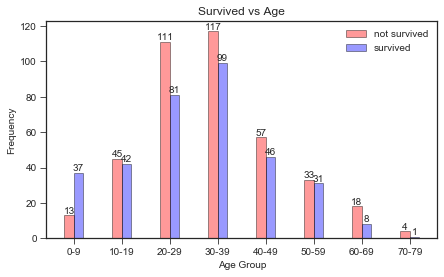

In [13]:
# Lets graph that
# 1- Bar Graphs- A bivariate graph, to compare 2 categories of variables, like the age of students in a class or even a histogram with discrete count(where u set the height)

import numpy as np
#Use this to increase size of graph ( width,height)
plt.figure(figsize=(7,4))
#Use this line to set the graph style
plt.style.use('seaborn-ticks')
#This displays the set of available styles
# print(plt.style.available)
plt.title("Survived vs Age") #To assign a title to the graph
plt.xlabel("Age Group") #To assign a label to x axis
plt.ylabel("Frequency") #To assign a label to y axis

index = np.arange(8)
x = list(age_survived.index)
y1 = age_survived.Not_survived
y2 = age_survived.Survived

survived_plt_position = np.array(range(8))
notsurvived_plt_position = np.array(range(8))+.2
tick_spacing = np.array(range(8))+0.1
width = 0.2
bar1 = plt.bar(survived_plt_position, y1 ,width = width,color = 'red',alpha = .4,edgecolor = 'black',label = 'not survived') #To map x and y axis on the graph
bar2 = plt.bar(notsurvived_plt_position, y2 ,width = width,color = 'blue',alpha = .4,edgecolor = 'black',label = 'survived')
#If you want to display the labels of the bar graphs
for bar in bar1:
    yval = bar.get_height()
    #Displaying the text, va - vertical alignment & ha - horizontal alignment
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom',ha = 'center') 
for bar in bar2:
    yval = bar.get_height()
    #Displaying the text, va - vertical alignment & ha - horizontal alignment
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom',ha = 'center') 

plt.xticks(tick_spacing,  list(age_survived.index))
plt.legend()  
plt.show() #To display the graph

#So between the age group of 20 to 40 is where there are a most number of poeple who died

In [14]:
pandas_df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home_dest,age_group
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,"St Louis, MO",20-29
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",0-9
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",0-9
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",30-39
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON",20-29


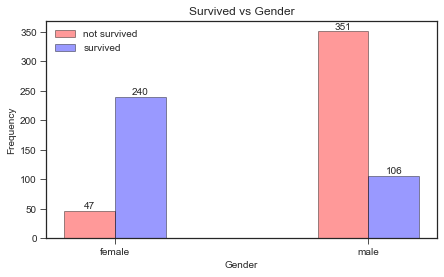

In [15]:
#Let us understand the sex vs survived population
df_sex = pd.crosstab(pandas_df['sex'],pandas_df['survived'])
df_sex.columns = ['Not_survived','Survived']
#Use this to increase size of graph ( width,height)
plt.figure(figsize=(7,4))
#Use this line to set the graph style
plt.style.use('seaborn-ticks')
#This displays the set of available styles
# print(plt.style.available)
plt.title("Survived vs Gender") #To assign a title to the graph
plt.xlabel("Gender") #To assign a label to x axis
plt.ylabel("Frequency") #To assign a label to y axis


x = list(df_sex.index)
y1 = df_sex.Not_survived
y2 = df_sex.Survived

survived_plt_position = np.array(range(len(y1)))
notsurvived_plt_position = np.array(range(len(y1)))+.2
tick_spacing = np.array(range(len(y1)))+.1
width = 0.2
bar1 = plt.bar(survived_plt_position, y1 ,width = width,color = 'red',alpha = .4,edgecolor = 'black',label = 'not survived') #To map x and y axis on the graph
bar2 = plt.bar(notsurvived_plt_position, y2 ,width = width,color = 'blue',alpha = .4,edgecolor = 'black',label = 'survived')
#If you want to display the labels of the bar graphs
for bar in bar1:
    yval = bar.get_height()
    #Displaying the text, va - vertical alignment & ha - horizontal alignment
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom',ha = 'center') 
for bar in bar2:
    yval = bar.get_height()
    #Displaying the text, va - vertical alignment & ha - horizontal alignment
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom',ha = 'center') 

plt.xticks(tick_spacing,  x)
plt.legend()  
plt.show() #To display the graph


In [16]:
#Let us see how much survived in each Pclass distributed
pclass_pd = pd.crosstab(pandas_df.pclass,pandas_df.survived)
pclass_pd.index = ['1st_Class','2nd_Class','3rd_Class']
pclass_pd.columns = ['Not_Survived','Survived']
pclass_pd

,Not_Survived,Survived
1st_Class,114,174
2nd_Class,144,117
3rd_Class,140,55


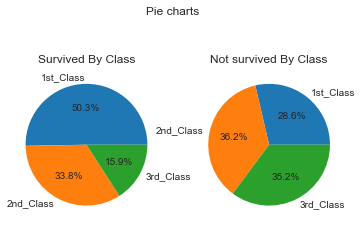

In [17]:
#Let us visualize in the form of pie charts
fig,(ax1,ax2) = plt.subplots(nrows = 1,ncols = 2)
import squarify
volume_survived = pclass_pd.Survived
volume_not_survived = pclass_pd.Not_Survived
labels = list(pclass_pd.index)
ax1.pie(volume_survived,autopct = '%1.1f%%',labels = labels )
ax1.set_title('Survived By Class')
ax2.pie(volume_not_survived,autopct = '%1.1f%%',labels = labels)
ax2.set_title('Not survived By Class')
plt.suptitle('Pie charts')
plt.show()

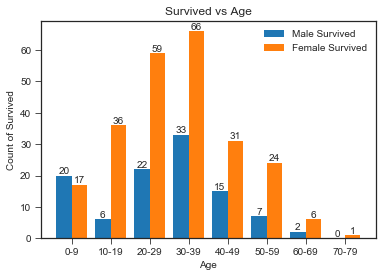

In [18]:
# Let us understand how gender survived w.r.t age groups
survived_male = pandas_df[pandas_df.sex =='male'].groupby('age_group').survived.sum().values
survived_female = pandas_df[pandas_df.sex =='female'].groupby('age_group').survived.sum().values
index = list(pandas_df[pandas_df.sex =='male'].groupby('age_group').survived.sum().index)
fig,ax = plt.subplots()
male_pos = np.arange(len(index))-.2
female_pos = np.arange(len(index))+.2
width = 0.4
bar1 = ax.bar(male_pos,survived_male,label = 'Male Survived',width = width)
bar2 = ax.bar(female_pos,survived_female,label = 'Female Survived',width =width)
tick_spacing = np.arange(len(index))
plt.xticks(tick_spacing,index)
plt.legend()
plt.title("Survived vs Age") #To assign a title to the graph
plt.xlabel("Age") #To assign a label to x axis
plt.ylabel("Count of Survived") #To assign a label to y axis
for bar in bar1:
    yval = bar.get_height()
    #Displaying the text, va - vertical alignment & ha - horizontal alignment
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom',ha = 'center') 
for bar in bar2:
    yval = bar.get_height()
    #Displaying the text, va - vertical alignment & ha - horizontal alignment
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom',ha = 'center') 

plt.show()

## Conclusions from our graph(S)
1. Between the age group 20 to 40 is the most causality (In the 1st graph)
2. More number of female survived than man
3. 1st class survived more than the other classes



In [13]:
train,test = df_new.randomSplit([0.8,0.2],0)
train.show(5)

+------+--------+--------------------+------+----+-----+-----+--------+------+--------+--------------------+
|pclass|survived|                name|   sex| age|sibsp|parch|  ticket|  fare|embarked|           home_dest|
+------+--------+--------------------+------+----+-----+-----+--------+------+--------+--------------------+
|     1|       0|"Lindeberg-Lind, ...|  male|42.0|    0|    0|   17475| 26.55|       S|   Stockholm, Sweden|
|     1|       0|"Rosenshine, Mr. ...|  male|46.0|    0|    0|PC 17585|  79.2|       C|        New York, NY|
|     1|       0|Allison, Miss. He...|female| 2.0|    1|    2|  113781|151.55|       S|Montreal, PQ / Ch...|
|     1|       0|Allison, Mr. Huds...|  male|30.0|    1|    2|  113781|151.55|       S|Montreal, PQ / Ch...|
|     1|       0|Allison, Mrs. Hud...|female|25.0|    1|    2|  113781|151.55|       S|Montreal, PQ / Ch...|
+------+--------+--------------------+------+----+-----+-----+--------+------+--------+--------------------+
only showing top 5 

In [11]:
#Let us try modelling & try to predict the best.we will be trying simple logistic regression,Random Forests and GBT classifier.
#With those 3 models, Let us evaluate the parameters and get the best model
from pyspark.ml import feature,Pipeline
from pyspark.ml import classification
numerical = Pipeline(stages = [feature.VectorAssembler(inputCols=['pclass', 'age', 'sibsp', 'parch', 'fare'],outputCol='featuresSS'),
                               feature.StandardScaler(inputCol = 'featuresSS',outputCol = 'featuresS')])
                               
pclass = Pipeline(stages = [feature.StringIndexer(inputCol = 'pclass',outputCol = 'pclass_code'),
                            feature.OneHotEncoder(inputCol = 'pclass_code',outputCol = 'pcl')])
sex = feature.StringIndexer(inputCol = 'sex',outputCol = 'sex_coded')
age = feature.QuantileDiscretizer(numBuckets = 8,inputCol = 'age',outputCol = 'age_bin')
fare = feature.QuantileDiscretizer(numBuckets = 8,inputCol = 'fare',outputCol = 'fare_bin')
embark = Pipeline(stages = [feature.StringIndexer(inputCol = 'embarked',outputCol = 'embark_code'),
                            feature.OneHotEncoder(inputCol = 'embark_code',outputCol = 'embarK')])
                        
feature_pipe = Pipeline(stages=[numerical,pclass,sex,age,fare,embark,
                                feature.VectorAssembler(inputCols = ['featuresSS','pcl','age_bin','fare_bin','embarK','sex_coded'],outputCol = 'features')])
                          
                                             



In [14]:
#Let us initialize the 3 models as discussed.
from pyspark_pipes import pipe
LR = classification.LogisticRegression(labelCol='survived', featuresCol='features')
RF = classification.RandomForestClassifier(labelCol = 'survived', featuresCol='features')
GBM = classification.GBTClassifier(labelCol = 'survived', featuresCol='features')
#Let us use the accuracy,precision,recall as our classification metrics


LR_df = Pipeline(stages = [feature_pipe,LR]).fit(train)
RF_df = Pipeline(stages = [feature_pipe,RF]).fit(train)
GBM_df = Pipeline(stages = [feature_pipe,GBM]).fit(train)



In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

models = [LR_df,RF_df,GBM_df]
evaluator = BinaryClassificationEvaluator(labelCol = 'survived',rawPredictionCol = 'rawPrediction')
for model in models:
    tranformed_test = model.transform(test)
    y_true = tranformed_test.select(['survived']).collect()
    y_pred = tranformed_test.select(['prediction']).collect()
    
    print(classification_report(y_true, y_pred))
    

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        85
           1       0.74      0.70      0.72        69

    accuracy                           0.75       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.75      0.75      0.75       154

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        85
           1       0.87      0.70      0.77        69

    accuracy                           0.82       154
   macro avg       0.83      0.81      0.81       154
weighted avg       0.83      0.82      0.81       154

              precision    recall  f1-score   support

           0       0.78      0.87      0.82        85
           1       0.81      0.70      0.75        69

    accuracy                           0.79       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.79      0.79      0.79       154



#Conclusions - Modelwise
The precision for the random forest classifier is .87(Best out of all the three), indicating that random forest classifier is the best in predicting positive outcomes(In this case 1 for predicting if a person survived or not).
Also out of all the three - f1 score is highest in the random forest, So that is the winner.


#Further Improvement that can be done to this case study
1.Cross validation
2.Introduce regularisation params
3.More hyper-tune the models.
4.Use decision tree to find out the important features that helps in prediction.